In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_hc = pd.read_csv('train.csv', index_col=0)
df_hc.head()

,lepton_1_pT,lepton_1_eta,lepton_1_phi,lepton_2_pT,lepton_2_eta,lepton_2_phi,missing_energy_magnitude,missing_energy_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1),class
0,0.841381,1.832647,-0.689286,0.781839,0.572864,1.577097,0.398978,-0.683847,0.001826,0.651397,0.865560,0.429017,0.439840,0.000000,0.796105,0.342497,0.461542,0.005710,0.0
1,0.663798,2.058290,0.681435,1.054036,0.575352,-1.001445,0.462154,-0.833411,0.199734,0.215158,0.949988,0.618046,0.577324,0.000000,0.962927,0.333800,1.455247,0.101246,0.0
2,1.792225,-1.099978,0.088109,0.573157,-0.472629,1.642084,1.203374,1.506731,0.457695,-0.640507,1.157024,1.585432,1.215963,0.000000,1.113292,0.645729,0.721326,0.613326,1.0
3,0.893018,0.297782,-1.274870,1.316164,1.593303,0.672115,0.307014,-1.189868,0.064561,0.430909,1.162625,0.548821,0.418897,0.163908,1.157707,0.298163,0.803802,0.038902,0.0
4,1.338997,0.350023,-1.518510,1.482963,-0.491807,0.340170,0.415071,-1.292034,0.240712,0.611775,1.307798,0.697804,0.473487,0.429977,1.287935,0.330327,0.717237,0.003147,1.0


In [3]:
df_hcc = df_hc.copy()

# Preprocessing

In [4]:
df_hcc.columns

Index(['lepton_1_pT', 'lepton_1_eta', 'lepton_1_phi', 'lepton_2_pT',
       'lepton_2_eta', 'lepton_2_phi', 'missing_energy_magnitude',
       'missing_energy_phi', 'MET_rel', 'axial_MET', 'M_R', 'M_TR_2', 'R',
       'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)', 'class'],
      dtype='object')

<AxesSubplot:>

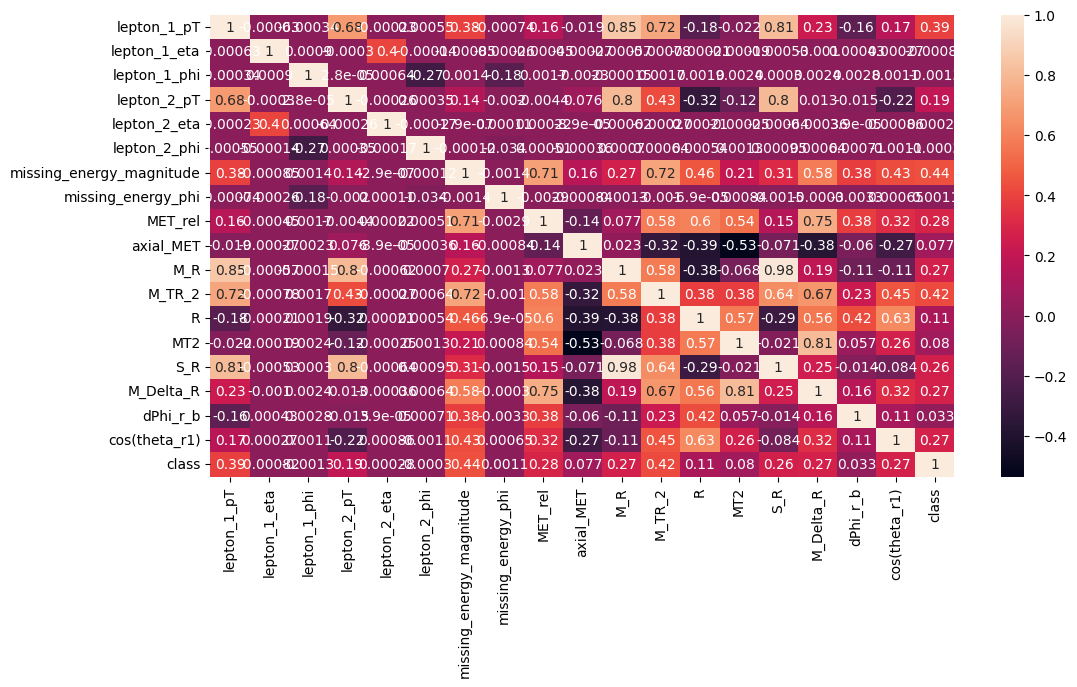

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df_hcc.corr(), annot=True)

<AxesSubplot:>

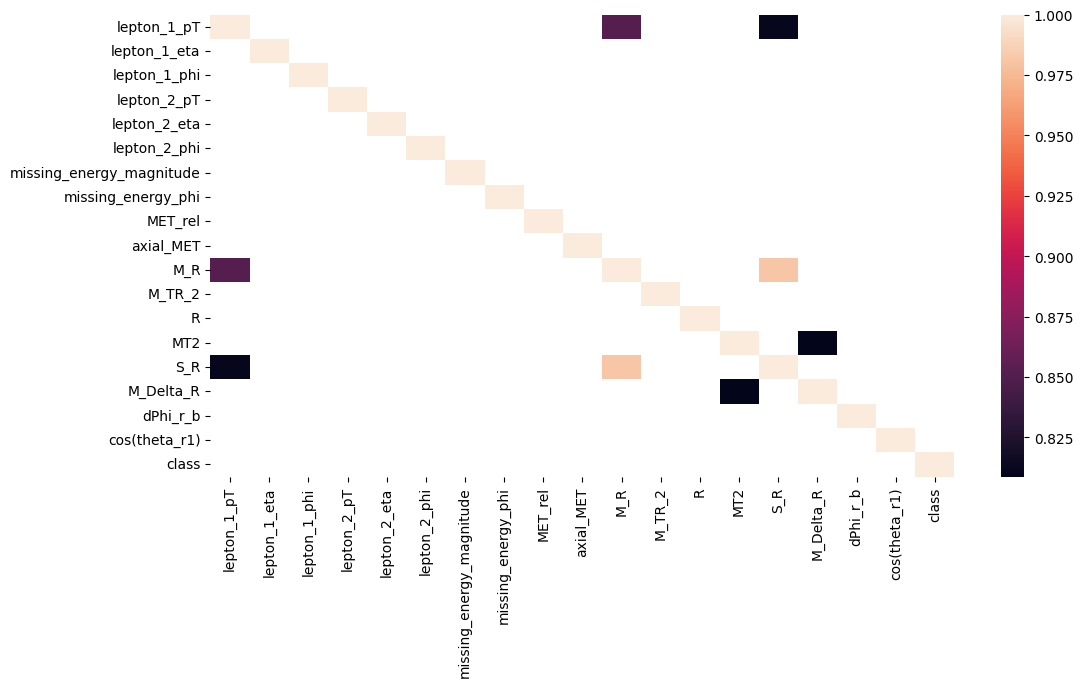

In [6]:
plt.figure(figsize=(12,6))
sns.heatmap(df_hcc.corr()[(np.abs(df_hcc.corr()) > 0.8)])

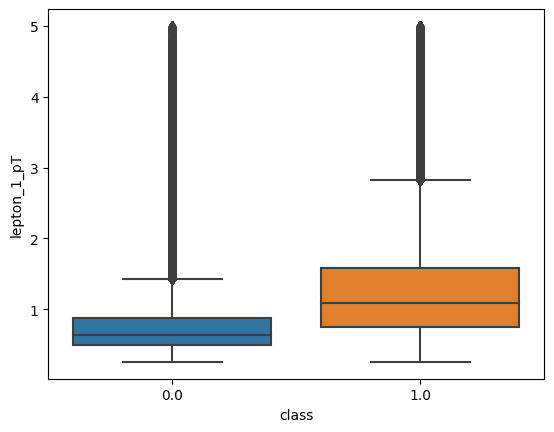

In [58]:
sns.boxplot(data=df_hcc, y='lepton_1_pT', x='class')
df_hcc=df_hcc[df_hcc['lepton_1_pT'] < 5]

In [8]:
# sns.boxplot(data=df_hcc, y='lepton_2_pT', x='class')
# df_hcc=df_hcc[df_hcc['lepton_2_pT'] < 3]

In [9]:
df_hcc.shape

(3491438, 19)

In [10]:
df_hcc = df_hcc.drop(columns =['lepton_1_phi', 'missing_energy_phi', 'lepton_2_phi'], axis=1)

# Split for Calculation and Scaling

In [11]:
X, y = df_hcc.loc[:, df_hcc.columns != 'class'].to_numpy(dtype=np.float_), df_hcc['class'].to_numpy(dtype=np.float_)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler_train_test = MinMaxScaler()
X_train = scaler_train_test.fit_transform(X_train)
X_test = scaler_train_test.transform(X_test)

scaler_full = MinMaxScaler()
X = scaler_full.fit_transform(X)

# Model Training

#### Random Forest Model

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
model_rf = RandomForestClassifier(n_estimators=160, n_jobs=-1, random_state=42)
model_rf.fit(X_train ,y_train)
model_rf.feature_importances_
model_rf.score(X_test, y_test)

0.8002572004674289

In [56]:
model_rf = RandomForestClassifier(n_estimators=160, n_jobs=-1, warm_start=True, random_state=42)
model_rf.fit(X, y)
model_rf.score(X, y)

0.9999997135850616

In [287]:
model_rf.predict(X)

array([0., 0., 1., ..., 1., 0., 0.])

In [288]:
model_rf.n_estimators=160
bad = (model_rf.predict(X) !=  y)
X_bad, y_bad = X[bad], y[bad]
model_rf.fit(X_bad, y_bad)
model_rf.score(X, y)

0.9999799509543059

#### Gradient Boost Model

In [30]:
from sklearn.ensemble import HistGradientBoostingClassifier
model_xg = HistGradientBoostingClassifier(l2_regularization=0.2, max_leaf_nodes=150, random_state=42)
model_xg.fit(X_train, y_train)
model_xg.score(X_test, y_test)

0.8031227802854982

In [127]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'learning_rate': (0.01, 0.1),
    'random_state': [42],
    'max_leaf_nodes': (200, 250, 300),
    'l2_regularization': (0.3, 0.4, 0.5)}

model_grid_search = GridSearchCV(HistGradientBoostingClassifier(), param_grid=param_grid,
                                 n_jobs=-1, cv=5, verbose=2)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [48]:
print(model_grid_search.best_params_)
print(model_grid_search.best_estimator_)
model_grid_search.score(X_test, y_test)

NameError: name 'model_grid_search' is not defined

In [31]:
# model_xg = HistGradientBoostingClassifier(l2_regularization=model_grid_search.best_params_['l2_regularization'],
#                                 learning_rate=model_grid_search.best_params_['learning_rate'],
#                                 max_leaf_nodes=model_grid_search.best_params_['max_leaf_nodes'], random_state=42)

model_xg = HistGradientBoostingClassifier(l2_regularization=0.4, max_leaf_nodes=250, learning_rate=0.1, random_state=42)
model_xg.fit(X_train, y_train)
model_xg.score(X_test, y_test)

0.8032337660105859

In [36]:
bad = (model_xg.predict(X) !=  y)
X_bad, y_bad = X[bad], y[bad]

model_xg_new = HistGradientBoostingClassifier(l2_regularization=0.4, max_leaf_nodes=250, learning_rate=0.1, random_state=42)

model_xg_new.fit(X_bad, y_bad)
model_xg_new.score(X_bad, y_bad)

0.9744256182647649

In [61]:
y_pr = np.array([0.0]*len(y))
for i,ele in enumerate(X):
    if ele[0] <= 0.4:
        y_pr[i] = model_xg_new.predict(ele.reshape(1,-1))
    else:
        y_pr[i] = model_xg.predict(ele.reshape(1,-1))
(y_pr == y)/len(y)

KeyboardInterrupt: 

In [86]:
model_xg_new.score(X[(X[:,0]  0.3).nonzero()[0]], y[(X[:,0] > 0.3).nonzero()[0]])

0.13365519178340896

<AxesSubplot:xlabel='class', ylabel='lepton_1_pT'>

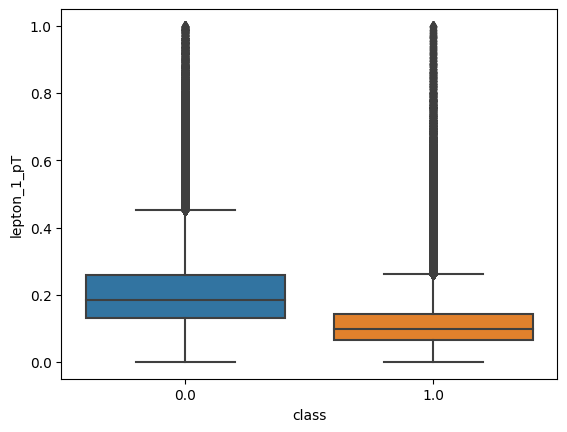

In [35]:
dct = {col:data for col,data in list(zip(df_hcc.columns, X_bad.T))}
dct['class'] = y_bad
sns.boxplot(data=pd.DataFrame(dct), y='lepton_1_pT', x='class')


In [63]:
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     model_xg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
# )
# sorted_importances_idx = result.importances_mean.argsort()
# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=df_hcc.columns[sorted_importances_idx],
# )
# importances

In [149]:
# model_xg = HistGradientBoostingClassifier(l2_regularization=model_grid_search.best_params_['l2_regularization'],
#                                 learning_rate=model_grid_search.best_params_['learning_rate'],
#                                 max_leaf_nodes=model_grid_search.best_params_['max_leaf_nodes'], random_state=42)

model_xg = HistGradientBoostingClassifier(l2_regularization=0.4, max_leaf_nodes=250, learning_rate=0.1, random_state=42)
model_xg.fit(X, y)
model_xg.score(X, y)

0.8059249512664982

#### Adaboost Model

In [328]:
from sklearn.ensemble import AdaBoostClassifier
model_ada = AdaBoostClassifier(n_estimators=150, learning_rate=0.1)
model_ada.fit(X_train, y_train)
model_ada.score(X_test, y_test)

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'n_jobs'

#### SVM

In [54]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC

# model_sgd = SGDClassifier(n_jobs=-1, random_state=42, loss='log_loss', penalty='elasticnet', l1_ratio=0.1)
# model_sgd.fit(X_train, y_train)
# model_sgd.score(X_test, y_test)
# model = LinearSVC(random_state=42)
# model.fit(X_train, y_train)

In [56]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'loss' : ['hinge', 'log_loss', 'log', 'modified_huber'],# 'squared_hinge'],# 'perceptron'],
    'random_state': [42],
    'penalty': ['elasticnet'],
    'l1_ratio': [0.2],# 0.4],
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    }

model_grid_svm = GridSearchCV(SGDClassifier(n_jobs=-1), param_grid=param_grid,
                                 n_jobs=-1, cv=5, verbose=2)
model_grid_svm.fit(X_train, y_train)
model_grid_svm.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0.7652551669225305

In [57]:
model_sgd = SGDClassifier(loss=model_grid_svm.best_params_['loss'],
            penalty='elasticnet', l1_ratio=0.2, random_state=42, alpha=model_grid_svm.best_params_['alpha'])
model_sgd.fit(X, y)
model_sgd.score(X, y)

0.7633487978305787

#### Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB
params_NB = {'var_smoothing': np.logspace(0,-9, num=20)}
gs_NB = GridSearchCV(estimator=GaussianNB(), 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(X_train, y_train)
gs_NB.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


0.7399654583782049

In [53]:
model_nb = GaussianNB(var_smoothing=gs_NB.best_params_['var_smoothing'])
model_nb.fit(X, y)
model_nb.score(X, y)

0.7392905158275759

#### VC

In [68]:
from sklearn.ensemble import VotingClassifier
model_vc = VotingClassifier(estimators=[('rf', model_rf), ('nb', model_nb), ('hgb', model_xg), ('sgd', model_sgd)]
                            , voting='soft')
model_vc.fit(X_train, y_train)
model_vc.score(X_test, y_test)

0.7874279666842334

# Final Predictions 

In [150]:
# X_t = pd.read_csv('test.csv', index_col=0).to_numpy(dtype=np.float_)
X_t = pd.read_csv('test.csv', index_col=0).drop(columns=['lepton_1_phi', 'missing_energy_phi', 'lepton_2_phi'], axis=1).to_numpy(dtype=np.float_)
X_t = scaler_full.transform(X_t)
# output_rf = pd.Series(model_rf.predict(X_t), name='class')
output_xg = pd.Series(model_xg.predict(X_t), name='class')

ValueError: X has 15 features, but MinMaxScaler is expecting 14 features as input.

In [ ]:
# output_rf.to_csv('res_rf.csv', index=True, index_label='Id')
output_xg.to_csv('res_xg.csv', index=True, index_label='Id')

In [151]:
y_ay = pd.read_csv('y_ayush.csv', index_col=0)
y_ay['class']
# print(np.sum(output_rf == y_ay['class'])/len(output_rf))
print(np.sum(output_xg == y_ay['class'])/len(output_xg))

0.9738213333333333
